## 2. 確率分布と統計モデリングの最尤推定
### 2.1 例題:種子数の統計モデリング
植物50体からなる集団を調査していて、各個体の種子数を数えたデータがあるとする。  
このデータはカウントデータであり、非負の整数である。

In [1]:
import numpy as np

data = np.loadtxt('rdata1.txt')

In [2]:
data

array([2., 2., 4., 6., 4., 5., 2., 3., 1., 2., 0., 4., 3., 3., 3., 3., 4.,
       2., 7., 2., 4., 3., 3., 3., 4., 3., 7., 5., 3., 1., 7., 6., 4., 6.,
       5., 2., 4., 7., 2., 2., 6., 2., 4., 5., 4., 5., 1., 3., 2., 3.])

データの個数を確認する。

In [3]:
len(data)

50

標本平均や標準偏差などの統計量を確認する。

In [4]:
import pandas as pd

pd.DataFrame(pd.Series(data.ravel()).describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
0,50.0,3.56,1.72804,0.0,2.0,3.0,4.75,7.0


度数分布の確認。

In [18]:
np.histogram(data, bins=8)

(array([ 1,  3, 11, 12, 10,  5,  4,  4], dtype=int64),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]))

ヒストグラムの表示

(array([ 1.,  3., 11., 12., 10.,  5.,  4.,  4.]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <BarContainer object of 8 artists>)

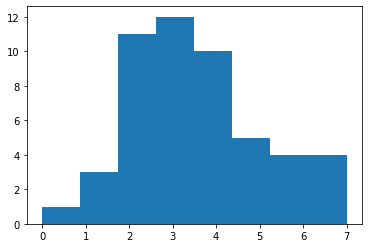

In [6]:
import matplotlib.pyplot as plt

plt.hist(data, bins=8)

データのばらつきを表す統計量として、標本分散がある。

In [7]:
np.var(data, ddof=1)

2.986122448979592

標本標準偏差は標本分散の平方根となる。

In [8]:
print(np.std(data, ddof=1))
print(np.sqrt(np.var(data, ddof=1)))

1.728040060004279
1.728040060004279


### 2.2 データと確率分布の対応関係を眺める
植物の種子数データは
- 1個、2個と数えるカウントデータ
- 1個体の標本平均は3.56個
- 個体ごとに種子数にばらつきがあり、ヒストグラムではひと山の分布

という特徴があることが分かった。  
とりあえず**ポアソン分布**と呼ばれる**確率分布**で表現することを考える。  
確率分布とは、**確率変数**の値とそれが出現する確率を対応させたものである。  
確率分布は比較的簡単な数式で定義され、**パラメータ**の値に依存して分布の形が変わる。  
  
ここで、「平均3.56のポアソン分布」を考える。  
「平均3.56のポアソン分布」に従って「種子数がyであると観測される確率」を生成させる。

[0 1 2 3 4 5 6 7 8 9] 
 [0.02843882 0.10124222 0.18021114 0.21385056 0.190327   0.13551282
 0.08040427 0.04089132 0.01819664 0.00719778]


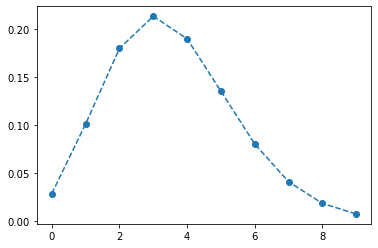

In [9]:
from scipy.stats import poisson

y = np.arange(0,10)
prob = poisson.pmf(y, mu=3.56)

plt.plot(y, prob, '--o')

print(y.T, '\n', prob)

観測データのヒストグラムに平均3.56のポアソン分布を重ねると、  
観測されたばらつきはポアソン分布で表現されそうと予測できる。

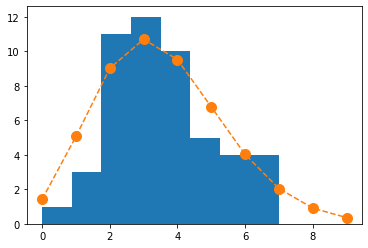

In [10]:
plt.hist(data, bins=8)
plt.plot(y, prob*50, '--o',markersize=10)

### 2.3 ポアソン分布
ポアソン分布は次の数式で定義される。
$$
p(y|\lambda)=\frac{\lambda^y\exp{(-\lambda)}}{y!}
$$
この式は、平均が$\lambda$のときに、ポアソン分布にしたがう確率変数が$y$という値になる確率である。  
ポアソン分布の性質を挙げる。
- $y\in\{0,1,2,\cdots,\infty\}$の値をとり、すべての$y$について和をとると1になる
$$
\sum_{y=0}^{\infty}p(y|\lambda)=1
$$
- 確率分布の平均は$lambda$である($\lambda \geqq 0$)
- 分散と平均は等しい:$\lambda$=平均=分散

ここで、ポアソン分布のパラメータ$\lambda$を変化させると、確率分布は図のように変化する。

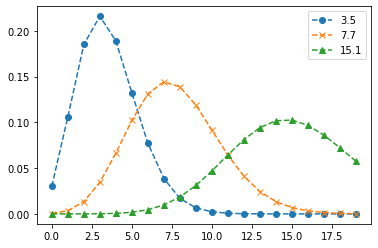

In [11]:
y = np.arange(0,20)

plt.plot(y, poisson.pmf(y, mu=3.5), '--o', label='3.5')
plt.plot(y, poisson.pmf(y, mu=7.7), '--x', label='7.7')
plt.plot(y, poisson.pmf(y, mu=15.1), '--^', label='15.1')
plt.legend()

なぜポアソン分布が選ばれたのか、その理由としては下のようなものが挙げられる。

1. データに含まれている値$y_i$が$\{0,1,2,\cdots\}$といった非負の整数である(カウントデータである)
2. $y_i$に下限(ゼロ)はあるが、上限については不明
3. この観測データでは平均と分散がだいたい等しい

その他にもいくつか前提が必要であるが、それらは成立しているとここでは考える。

### 2.4 ポアソン分布のパラメータの最尤推定
確率分布のパラメータを、観測データに基づいて推定する方法を考える。  
最尤推定法は尤度という「あてはまりの良さ」を表す統計量を最大にするパラメータ推定方法である。  
尤度の実態は、ある$\lambda$の値を決めた時の、すべての個体$i$についての$p(y_i|\lambda)$の積である。  
たとえば、データが3個分$\{y_1,y_2,y_3\}=\{2,2,4\}$だった場合、  
尤度はだいたい$0.180×0.180×0.190=0.006156$といった値になる。  
  
尤度はパラメータの関数であるので$L(\lambda)$と書き、この例題では次のように定義される。
$$
\begin{align}
L(\lambda)&=(y_1が2である確率)×(y_2が2である確率)×\cdots×(y_50が3である確率)\\
&=p(y_1|\lambda)×p(y_1|\lambda)×p(y_1|\lambda)×\cdots×p(y_1|\lambda)\\
&=\prod_{i}p(y_i|\lambda)\\
&=\prod_{i}\frac{\lambda^{y_i}\exp{(-\lambda)}}{y_i!}
\end{align}
$$
対数尤度関数は、
$$
\log{L(\lambda)}=\sum_i\biggl(y_i\log{\lambda}-\lambda-\sum_{k}^{y_i}\log{k}\biggr)
$$

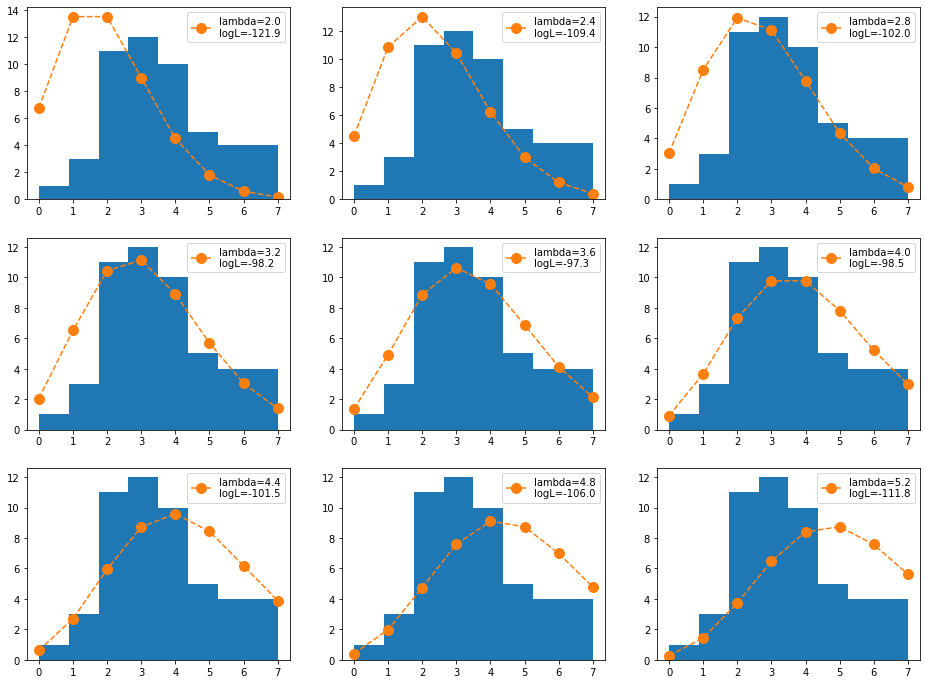

In [12]:
fig = plt.figure(figsize=(16,12))
x = np.arange(8)
mu = np.arange(2.0, 5.6, 0.4)

calc_logL = lambda x, mu: np.sum(np.log(poisson.pmf(x, mu=mu)))

for i in range(9):
    logL = np.round(calc_logL(data, mu[i]), decimals=1)
    prob = poisson.pmf(x, mu=mu[i])
    label = 'lambda={}\nlogL={}'.format(np.round(mu[i], decimals=1), logL)
    
    ax = fig.add_subplot(3, 3, i+1)
    ax.hist(data, bins=8)
    ax.plot(x, prob*50, '--o',markersize=10, label=label)
    ax.legend()

対数尤度と$\lambda$の関係を調べる。

max logL : -97.24400294080664
lambda_hat : 3.5599999999999667


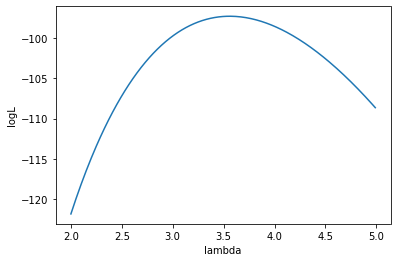

In [17]:
lmd = np.arange(2, 5, 0.01)

logL = np.array([calc_logL(data, l) for l in lmd])
max_idx = np.argmax(logL)

print('max logL :', logL[max_idx])
print('lambda_hat :', lmd[max_idx])

plt.plot(lmd, logL);
plt.xlabel('lambda');
plt.ylabel('logL');

対数尤度が最大になる$\lambda$を$\hat{\lambda}$とする。  
対数尤度関数が最大値で関数の傾きがゼロとなる$\lambda$を探しだせばよい。  
$$
\frac{\partial \log{L(\lambda)}}{\partial \lambda}=\sum_i\biggl\{\frac{y_i}{\lambda}-1 \biggr\}=\frac{1}{\lambda}\sum_iy_i-50
$$
これがゼロである場合、
$$
\hat{\lambda}=\frac{1}{50}\sum_iy_i=\frac{全部のy_iの和}{データ数}=データの標本平均=3.56
$$
となる。  
最尤推定値$\hat{\lambda}$は3.56であり、標本平均に等しくなる。  
このように対数尤度または尤度が最大になる$\hat{\lambda}$を**最尤推定量** 、  
具体的な$y_i$の値を使って評価された$\hat{\lambda}=3.56$のことを**最尤推定値**と呼ぶ。  
  
一般化すると、$\theta$をパラメータとする確率分布から観測データ$y_i$が発生した場合、その確率を$p(y|\theta)$とすると、尤度は、
$$
L(\theta|\boldsymbol{Y})=\prod_ip(y_i|\theta)
$$
対数尤度は、
$$
\log{L(\theta|\boldsymbol{Y})}=\sum_i\log{p(y_i|\theta)}
$$
であり、最尤推定はこの対数尤度を最大にするような$\hat{\theta}$を探すことである。

### 2.5 統計モデルの要点
データが与えられたとき、「こういうばらつきのあるデータは、何か確率分布から発生した」と考える。  
データを発生させた統計モデルが「真の統計モデル」であり、これが平均3.56のポアソン分布であるとしている。  
観測データを見たときに「ポアソン分布で説明できる」と仮定したときに、「パラメータ$\lambda$の値は？」という問いに答えるのが**推定**である。  
また、**予測**とは、次のデータの分布を見積もることである。
- 次に得られる応答変数の平均だけを示す
- 平均だけでなく、次に得られるデータの範囲の予測区間を示す

### 2.6 確率分布の選び方
データを見たら以下の点に気を付ける。
- 説明したい量は**離散**か**連続**か？
- 説明したい量の**範囲**は？
- 説明したい量の標本分散と標本平均の関係は？

ここでは、カウントデータの統計モデルで使う確率分布として
- **ポアソン分布**：データが離散値、ゼロ以上、上限なし、平均$\approx$分散
- **二項分布**：データが離散値、ゼロ以上で有限の範囲、分散は平均の関数
を使用する。

また、連続確率分布では、
- 正規分布：データが連続値、範囲が$[-\infty,\infty]$、分散は平均とは無関係
- ガンマ分布：データが連続値、範囲が$[0,\infty]$、分散は平均の関数

などがある。